In [30]:
import os
import re
import torch
import transformers
from tqdm import tqdm
import json
import numpy as np
from sklearn.metrics import cohen_kappa_score
from typing import Optional, Literal
from utils import load_asap_dataset, load_toefl_dataset, get_score_range
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

In [74]:
# DATASET = 'ASAP'
DATASET = 'TOEFL11'

# MODEL = "meta-llama/Llama-2-7b-chat-hf"
# MODEL = "meta-llama/Llama-3.1-8B-Instruct"
MODEL = "meta-llama/Llama-3.2-3B-Instruct"
# MODEL = "mistralai/Mistral-7B-Instruct-v0.2"

if DATASET == 'ASAP':
    df = load_asap_dataset('datasets/ASAP')
elif DATASET == 'TOEFL11':
    df = load_toefl_dataset('datasets/TOEFL11')
df

essay_id,essay_set,original_score,essay,score
i64,i64,str,str,i32
10229,8,"""low""","""I DO NOT AGREE WITH THIS STATE…",0
10392,1,"""high""","""I am not quite sure about my o…",2
10445,3,"""medium""","""It is often said that young pe…",1
10535,7,"""medium""","""In mordern society, students a…",1
10769,1,"""high""","""I find it productive and rewar…",2
…,…,…,…,…
1175383,2,"""medium""",""" There are heated disscussion…",1
1175412,3,"""high""","""In my personal opinion young p…",2
1175488,8,"""medium""","""I believe that people who take…",1


In [75]:
import polars as pl
results = pl.read_csv(f"outputs/mts/{DATASET}_{MODEL.split('/')[1]}.csv")
results[['0', '1', '2', '3']]

0,1,2,3
i64,i64,i64,i64
1,2,2,2
4,6,5,5
8,6,7,7
4,3,5,4
7,6,7,7
…,…,…,…
4,5,4,4
5,6,5,5
4,3,4,4


In [76]:
def drop_rows_with_negative_one(df):
    """
    Polarsデータフレームから-1を含む行を削除する関数
    
    Parameters:
    -----------
    df : pl.DataFrame
        入力データフレーム
    
    Returns:
    --------
    pl.DataFrame
        -1を含む行が削除されたデータフレーム
    """
    # 各列について-1かどうかをチェックし、行ごとにいずれかの列が-1の場合にTrueとなるマスクを作成
    mask = df.select(
        pl.fold(
            False,
            lambda acc, x: acc | (x == -1),
            pl.all().exclude([])
        )
    ).to_series()
    
    # マスクの否定を使用して-1を含まない行だけを残す
    return df.filter(~mask)

In [77]:
final = pl.concat([df, results[['0', '1', '2', '3']]], how='horizontal')
final = drop_rows_with_negative_one(final)
final

essay_id,essay_set,original_score,essay,score,0,1,2,3
i64,i64,str,str,i32,i64,i64,i64,i64
10229,8,"""low""","""I DO NOT AGREE WITH THIS STATE…",0,1,2,2,2
10392,1,"""high""","""I am not quite sure about my o…",2,4,6,5,5
10445,3,"""medium""","""It is often said that young pe…",1,8,6,7,7
10535,7,"""medium""","""In mordern society, students a…",1,4,3,5,4
10769,1,"""high""","""I find it productive and rewar…",2,7,6,7,7
…,…,…,…,…,…,…,…,…
1175383,2,"""medium""",""" There are heated disscussion…",1,4,5,4,4
1175412,3,"""high""","""In my personal opinion young p…",2,5,6,5,5
1175488,8,"""medium""","""I believe that people who take…",1,4,3,4,4


In [78]:
final.describe()

statistic,essay_id,essay_set,original_score,essay,score,0,1,2,3
str,f64,f64,str,str,f64,f64,f64,f64,f64
"""count""",1099.0,1099.0,"""1099""","""1099""",1099.0,1099.0,1099.0,1099.0,1099.0
"""null_count""",0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",985185.592357,4.484986,null,null,1.21747,4.508644,4.399454,4.514104,4.301183
"""std""",307937.154371,2.325612,null,null,0.635203,1.414429,1.201714,1.198257,1.191694
"""min""",10229.0,1.0,"""high""",""" ""Jack of all trades, master o…",0.0,1.0,1.0,2.0,2.0
"""25%""",1.0308e6,2.0,null,null,1.0,4.0,4.0,4.0,3.0
"""50%""",1.080962e6,4.0,null,null,1.0,4.0,4.0,5.0,4.0
"""75%""",1.1272e6,7.0,null,null,2.0,6.0,5.0,5.0,5.0
"""max""",1.176184e6,8.0,"""medium""","""young peolple enjoy life more …",2.0,8.0,8.0,8.0,8.0


In [79]:
final = final.with_columns(
    ((pl.col('0') + pl.col('1') + pl.col('2') + pl.col('3'))/4).alias('trait_avg')
)
# essay_setごとにIQRでクリッピング
def clip_by_iqr(series, lower_limit=1.5, upper_limit=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - lower_limit * iqr
    upper_bound = q3 + upper_limit * iqr
    return series.clip(lower_bound, upper_bound)

clipped = final.group_by('essay_set').map_groups(lambda group:
    group.with_columns([
        pl.Series(clip_by_iqr(group['trait_avg'])).alias('trait_avg_agg')
    ])
)
clipped

essay_id,essay_set,original_score,essay,score,0,1,2,3,trait_avg,trait_avg_agg
i64,i64,str,str,i32,i64,i64,i64,i64,f64,f64
11644,6,"""medium""","""I agree with this statement. B…",1,4,4,4,4,4.0,4.0
104344,6,"""medium""","""Some people agree with the sta…",1,5,4,4,5,4.5,4.5
104726,6,"""high""","""The answer to this question de…",2,5,4,5,4,4.5,4.5
105677,6,"""low""","""I disagree with this statement…",0,4,4,4,5,4.25,4.25
105815,6,"""medium""","""Last summer, my wife and I wer…",1,6,6,5,5,5.5,5.5
…,…,…,…,…,…,…,…,…,…,…
1164179,2,"""medium""","""This is a very hard discussed …",1,4,5,5,4,4.5,4.5
1165738,2,"""medium""","""Since World war 2 was ended, Y…",1,2,3,3,3,2.75,2.75
1172289,2,"""medium""","""There are a lot of reasons and…",1,4,5,4,4,4.25,4.25


In [80]:
clipped.describe()

statistic,essay_id,essay_set,original_score,essay,score,0,1,2,3,trait_avg,trait_avg_agg
str,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64
"""count""",1099.0,1099.0,"""1099""","""1099""",1099.0,1099.0,1099.0,1099.0,1099.0,1099.0,1099.0
"""null_count""",0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",985185.592357,4.484986,null,null,1.21747,4.508644,4.399454,4.514104,4.301183,4.430846,4.420496
"""std""",307937.154371,2.325612,null,null,0.635203,1.414429,1.201714,1.198257,1.191694,1.118897,1.078135
"""min""",10229.0,1.0,"""high""",""" ""Jack of all trades, master o…",0.0,1.0,1.0,2.0,2.0,1.5,1.5
"""25%""",1.0308e6,2.0,null,null,1.0,4.0,4.0,4.0,3.0,3.75,3.75
"""50%""",1.080962e6,4.0,null,null,1.0,4.0,4.0,5.0,4.0,4.25,4.25
"""75%""",1.1272e6,7.0,null,null,2.0,6.0,5.0,5.0,5.0,5.25,5.25
"""max""",1.176184e6,8.0,"""medium""","""young peolple enjoy life more …",2.0,8.0,8.0,8.0,8.0,8.0,8.0


In [81]:
# essay_setごとにスコアを正規化（min-max変換）
normalized = clipped.group_by('essay_set').map_groups(lambda group: 
    group.with_columns([
        pl.col('trait_avg_agg').map_elements(
            lambda x: int(
                (x - group['trait_avg_agg'].min()) * (5 - 1) / (group['trait_avg_agg'].max() - group['trait_avg_agg'].min()) + 1
            ), return_dtype=pl.Int64
        ).alias('five_point_score')
    ])
)
normalized = normalized.with_columns(
    pl.when(pl.col('five_point_score') <= 2.25)
    .then(0)
    .when(pl.col('five_point_score') <= 3.75)
    .then(1)
    .otherwise(2).alias('normalized_score')
)
normalized

essay_id,essay_set,original_score,essay,score,0,1,2,3,trait_avg,trait_avg_agg,five_point_score,normalized_score
i64,i64,str,str,i32,i64,i64,i64,i64,f64,f64,i64,i32
11644,6,"""medium""","""I agree with this statement. B…",1,4,4,4,4,4.0,4.0,2,0
104344,6,"""medium""","""Some people agree with the sta…",1,5,4,4,5,4.5,4.5,3,1
104726,6,"""high""","""The answer to this question de…",2,5,4,5,4,4.5,4.5,3,1
105677,6,"""low""","""I disagree with this statement…",0,4,4,4,5,4.25,4.25,2,0
105815,6,"""medium""","""Last summer, my wife and I wer…",1,6,6,5,5,5.5,5.5,4,2
…,…,…,…,…,…,…,…,…,…,…,…,…
1174142,8,"""medium""","""Doing what you already can its…",1,6,4,4,4,4.5,4.5,2,0
1174410,8,"""medium""","""The term ""Successful"" is relat…",1,5,4,5,4,4.5,4.5,2,0
1175488,8,"""medium""","""I believe that people who take…",1,4,3,4,4,3.75,3.75,2,0


In [82]:
from scipy.stats import spearmanr
# essay_setごとにQWKとスピアマンの順位相関係数を計算
qwk_scores = []
spearman_scores = []
for essay_set in normalized['essay_set'].unique():
    subset = normalized.filter(pl.col('essay_set') == essay_set)
    minsocre, maxscore = get_score_range(DATASET, essay_set)
    qwk = cohen_kappa_score(
        subset['score'].to_numpy(),
        subset['normalized_score'].to_numpy(),
        weights='quadratic',
        labels=[i for i in range(minsocre, maxscore + 1)]
    )
    spearman_corr, _ = spearmanr(subset['score'].to_numpy(), subset['trait_avg'].to_numpy())
    qwk_scores.append({
        'essay_set': essay_set,
        'qwk': qwk
    })
    spearman_scores.append({
        'essay_set': essay_set,
        'spearman_corr': spearman_corr
    })

qwk_df = pl.DataFrame(qwk_scores)
spearman_df = pl.DataFrame(spearman_scores)
print("QWK scores by essay set:")
print(qwk_df)
print("スピアマンの順位相関係数 by essay set:")
print(spearman_df)

QWK scores by essay set:
shape: (8, 2)
┌───────────┬──────────┐
│ essay_set ┆ qwk      │
│ ---       ┆ ---      │
│ i64       ┆ f64      │
╞═══════════╪══════════╡
│ 1         ┆ 0.360596 │
│ 2         ┆ 0.388507 │
│ 3         ┆ 0.453785 │
│ 4         ┆ 0.455646 │
│ 5         ┆ 0.340807 │
│ 6         ┆ 0.363636 │
│ 7         ┆ 0.322618 │
│ 8         ┆ 0.298557 │
└───────────┴──────────┘
スピアマンの順位相関係数 by essay set:
shape: (8, 2)
┌───────────┬───────────────┐
│ essay_set ┆ spearman_corr │
│ ---       ┆ ---           │
│ i64       ┆ f64           │
╞═══════════╪═══════════════╡
│ 1         ┆ 0.648677      │
│ 2         ┆ 0.572243      │
│ 3         ┆ 0.71951       │
│ 4         ┆ 0.643992      │
│ 5         ┆ 0.531627      │
│ 6         ┆ 0.549069      │
│ 7         ┆ 0.607669      │
│ 8         ┆ 0.563284      │
└───────────┴───────────────┘


In [83]:
qwk_df['qwk'].mean()

0.373019260992612

In [84]:
spearman_df['spearman_corr'].mean()

0.6045088669979548

AttributeError: 'numpy.int32' object has no attribute 'startswith'

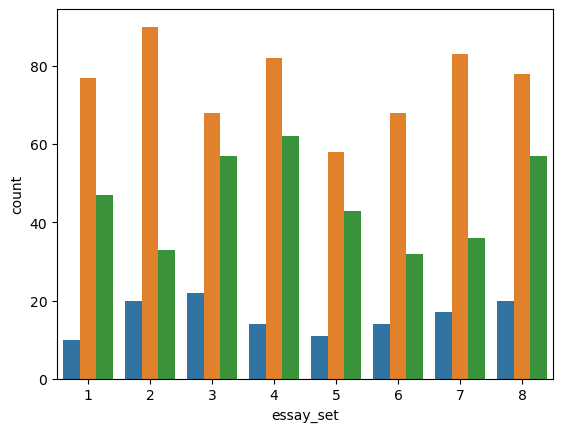

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=final.to_pandas(), x='essay_set', hue='score')
plt.show()

AttributeError: 'numpy.int64' object has no attribute 'startswith'

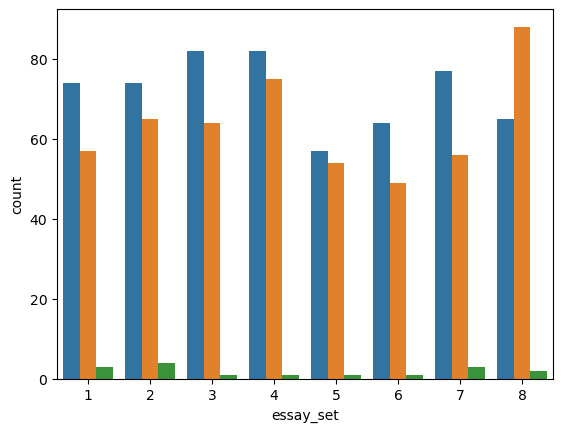

In [45]:
sns.countplot(data=normalized.to_pandas(), x='essay_set', hue='normalized_score')
plt.show()